In [19]:
import zipfile
import os


zip_file_path = '/home/sran-m36/Multi Modal Project/oasis2_preprocessed_images-20250330T192326Z-001.zip'


output_directory = '/home/sran-m36/Multi Modal Project/oasis_extracted_files'


os.makedirs(output_directory, exist_ok=True)


with zipfile.ZipFile(zip_file_path, 'r') as zip_ref:
    zip_ref.extractall(output_directory)

print(f"Files extracted to: {output_directory}")



Files extracted to: /home/sran-m36/Multi Modal Project/oasis_extracted_files


In [54]:
!pip install nilearn SimpleITK nibabel matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.4/10.4 MB 33.4 MB/s eta 0:00:00 0:00:01


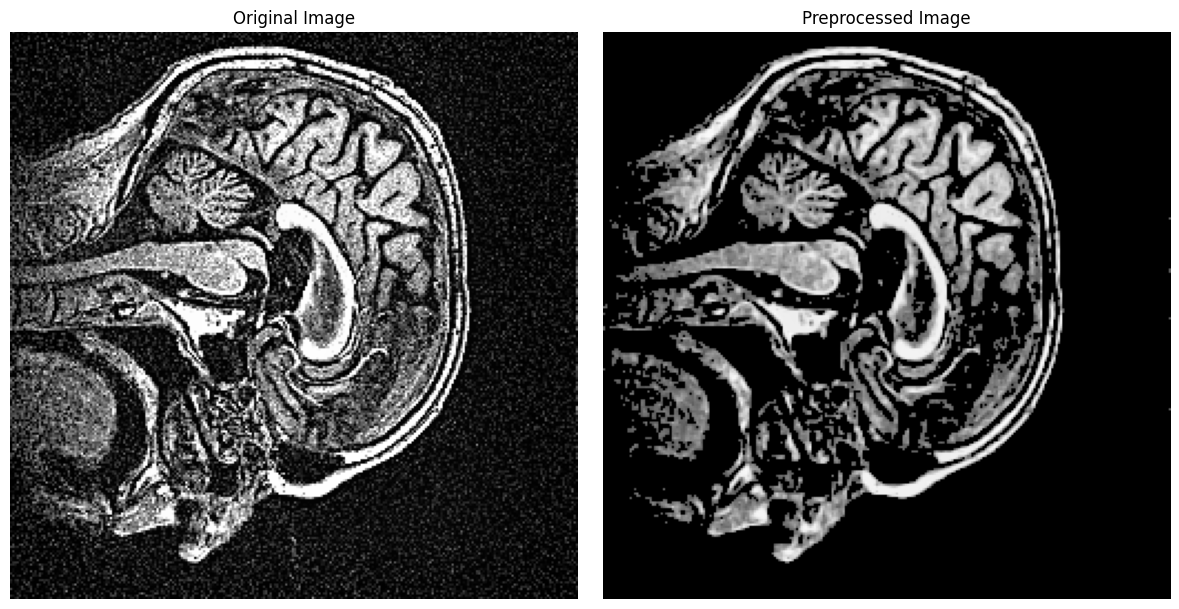

In [55]:
import numpy as np
import SimpleITK as sitk
import matplotlib.pyplot as plt
from nilearn import image
import nibabel as nib

# Load the image
image_path = 'oasis_extracted_files/oasis2_preprocessed_images/OAS2_0001_MR1.png'
input_image = sitk.ReadImage(image_path, sitk.sitkFloat32)

# Step 1: Denoising
img_denoised = sitk.CurvatureFlow(image1=input_image, timeStep=0.125, numberOfIterations=5)

# Step 2: N4 Bias Field Correction
corrector = sitk.N4BiasFieldCorrectionImageFilter()
img_corrected = corrector.Execute(img_denoised)

# Step 3: Skull Stripping 
thresh_filter = sitk.OtsuThresholdImageFilter()
thresh_filter.SetInsideValue(0)
thresh_filter.SetOutsideValue(1)
brain_mask = thresh_filter.Execute(img_corrected)
brain_extracted = sitk.Mask(img_corrected, brain_mask)

# Step 4: Intensity Normalization
brain_array = sitk.GetArrayFromImage(brain_extracted)
brain_array = (brain_array - np.min(brain_array)) / (np.max(brain_array) - np.min(brain_array))
brain_normalized = sitk.GetImageFromArray(brain_array)

# Display original and preprocessed images side by side
fig, axes = plt.subplots(1, 2, figsize=(12, 6))

# Original image
a = sitk.GetArrayFromImage(input_image)
axes[0].imshow(a, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')

# Preprocessed image
b = sitk.GetArrayFromImage(brain_normalized)
axes[1].imshow(b, cmap='gray')
axes[1].set_title('Preprocessed Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

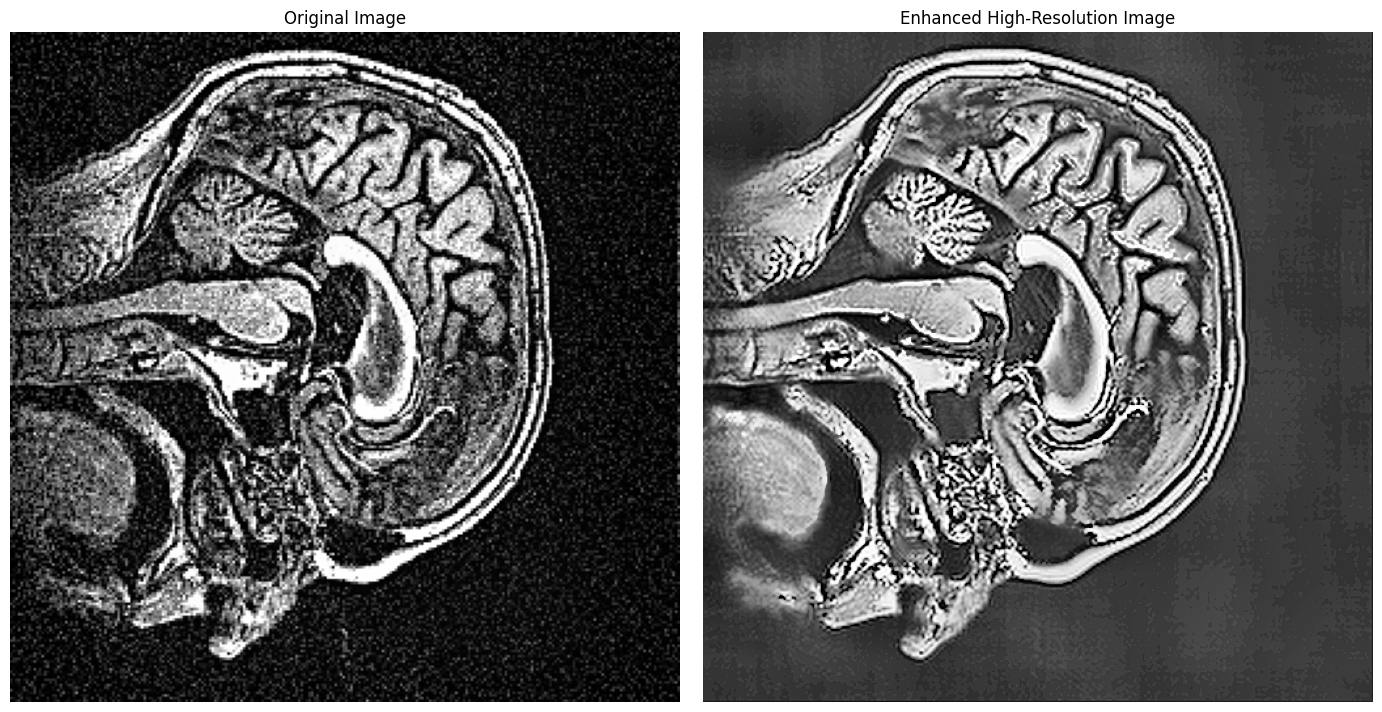

In [57]:
import SimpleITK as sitk
import numpy as np
import matplotlib.pyplot as plt
from skimage.restoration import denoise_nl_means, estimate_sigma
from skimage.exposure import equalize_adapthist
from skimage.filters import unsharp_mask

# Load original MRI image
image_path = 'oasis_extracted_files/oasis2_preprocessed_images/OAS2_0001_MR1.png'
img = sitk.ReadImage(image_path, sitk.sitkFloat32)
img_array = sitk.GetArrayFromImage(img)

# Step 1: Non-Local Means Denoising 
sigma_est = np.mean(estimate_sigma(img_array))
denoised_img = denoise_nl_means(img_array, h=1.15 * sigma_est, fast_mode=True)

# Step 2: High-resolution Interpolation 
resampler = sitk.ResampleImageFilter()
resampler.SetInterpolator(sitk.sitkBSpline)
new_spacing = [sz / 2 for sz in img.GetSpacing()]
original_size = np.array(img.GetSize())
new_size = (original_size * 2).astype(int).tolist()
resampler.SetOutputSpacing(new_spacing)
resampler.SetSize(new_size)
img_high_res = resampler.Execute(sitk.GetImageFromArray(denoised_img))

# Convert high-res image to numpy array
high_res_array = sitk.GetArrayFromImage(img_high_res)

# Normalize to [0, 1]
high_res_array -= high_res_array.min()
high_res_array /= high_res_array.max()

# Step 3: Contrast Enhancement (CLAHE)
enhanced_contrast = equalize_adapthist(high_res_array, clip_limit=0.03)

# Step 4: Sharpening (Unsharp Mask)
sharpened_img = unsharp_mask(enhanced_contrast, radius=1.0, amount=1.0)

# Visualize results
fig, axes = plt.subplots(1, 2, figsize=(14, 7))

# Original
axes[0].imshow(img_array, cmap='gray')
axes[0].set_title('Original Image')
axes[0].axis('off')


axes[1].imshow(sharpened_img, cmap='gray')
axes[1].set_title('Enhanced High-Resolution Image')
axes[1].axis('off')

plt.tight_layout()
plt.show()

In [12]:
import os
import pandas as pd

# Reload the CSV file
csv_file_path = "oasis_csv.csv"
metadata_df = pd.read_csv(csv_file_path)

processed_images_dir = "preprocessed_images_oasis"

metadata_image_ids = metadata_df["MRI ID"].astype(str)

# Build a list of image IDs from the filenames in the directory,
processed_image_ids = []
for file in os.listdir(processed_images_dir):
    if file.endswith(".png"):
        file_id, _ = os.path.splitext(file)  
        
        file_id = file_id.replace("MRI_ID_", "")  
        processed_image_ids.append(file_id)

# Filter CSV rows that match one of the processed image IDs
aligned_data = metadata_df[metadata_df["MRI ID"].astype(str).isin(processed_image_ids)]


missing_images = set(metadata_image_ids) - set(processed_image_ids)

aligned_data, missing_images


(    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
 1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
 2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
 3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
 4    OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80   
 5    OAS2_0004  OAS2_0004_MR1  Nondemented      1         0   F    R   88   
 ..         ...            ...          ...    ...       ...  ..  ...  ...   
 368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
 369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
 370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
 371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
 372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   
 
      EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
 1      14  2

In [2]:
import pandas as pd
import os

# load the CSV file
csv_file_path = "oasis_csv.csv"
metadata_df = pd.read_csv(csv_file_path)

# Define the processed images directory
processed_images_dir = "oasis_extracted_files/oasis2_preprocessed_images"

# Extract the Image Data ID column from the CSV file
metadata_image_ids = metadata_df["MRI ID"].astype(str)

# Get a list of processed image filenames 
processed_image_ids = [os.path.splitext(file)[0] for file in os.listdir(processed_images_dir) if file.endswith(".png")]

# Align metadata and processed images
aligned_data = metadata_df[metadata_df["MRI ID"].astype(str).isin(processed_image_ids)]

# Check if any images are missing from the processed images folder
missing_images = set(metadata_image_ids) - set(processed_image_ids)

# Output the aligned data and missing image IDs
aligned_data, missing_images

(    Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  \
 0    OAS2_0001  OAS2_0001_MR1  Nondemented      1         0   M    R   87   
 1    OAS2_0001  OAS2_0001_MR2  Nondemented      2       457   M    R   88   
 2    OAS2_0002  OAS2_0002_MR1     Demented      1         0   M    R   75   
 3    OAS2_0002  OAS2_0002_MR2     Demented      2       560   M    R   76   
 4    OAS2_0002  OAS2_0002_MR3     Demented      3      1895   M    R   80   
 ..         ...            ...          ...    ...       ...  ..  ...  ...   
 368  OAS2_0185  OAS2_0185_MR2     Demented      2       842   M    R   82   
 369  OAS2_0185  OAS2_0185_MR3     Demented      3      2297   M    R   86   
 370  OAS2_0186  OAS2_0186_MR1  Nondemented      1         0   F    R   61   
 371  OAS2_0186  OAS2_0186_MR2  Nondemented      2       763   F    R   63   
 372  OAS2_0186  OAS2_0186_MR3  Nondemented      3      1608   F    R   65   
 
      EDUC  SES  MMSE  CDR  eTIV   nWBV    ASF  
 0      14  2

In [28]:
from sklearn.model_selection import train_test_split
import pandas as pd

# Load the aligned data 
csv_file_path = "oasis_csv.csv"
aligned_data.to_csv("aligned_metadata_oasis.csv", index=False)

# Define train, validation, and test split ratios
train_ratio = 0.7
val_ratio = 0.15
test_ratio = 0.15


train_data, temp_data = train_test_split(aligned_data, test_size=(1 - train_ratio), random_state=42, stratify=aligned_data["Group"])


val_data, test_data = train_test_split(temp_data, test_size=(test_ratio / (test_ratio + val_ratio)), random_state=42, stratify=temp_data["Group"])

# Save the split data for reference
train_data.to_csv("train_data_oasis.csv", index=False)
val_data.to_csv("val_data_oasis.csv", index=False)
test_data.to_csv("test_data_oasis.csv", index=False)

print(f"Data split completed:")
print(f"Training set: {len(train_data)} samples")
print(f"Validation set: {len(val_data)} samples")
print(f"Test set: {len(test_data)} samples")

Data split completed:
Training set: 261 samples
Validation set: 56 samples
Test set: 56 samples


In [29]:

gender_counts = aligned_data['M/F'].value_counts()

# Display the results
print(gender_counts)

M/F
F    213
M    160
Name: count, dtype: int64


In [3]:

subject_counts = aligned_data['Subject ID'].count()

# Display the results
print(subject_counts)

373


In [4]:
aligned_data.head()

,Subject ID,MRI ID,Group,Visit,MR Delay,M/F,Hand,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
0,OAS2_0001,OAS2_0001_MR1,Nondemented,1,0,M,R,87,14,2.0,27.0,0.0,1987,0.696,0.883
1,OAS2_0001,OAS2_0001_MR2,Nondemented,2,457,M,R,88,14,2.0,30.0,0.0,2004,0.681,0.876
2,OAS2_0002,OAS2_0002_MR1,Demented,1,0,M,R,75,12,NaN,23.0,0.5,1678,0.736,1.046
3,OAS2_0002,OAS2_0002_MR2,Demented,2,560,M,R,76,12,NaN,28.0,0.5,1738,0.713,1.010
4,OAS2_0002,OAS2_0002_MR3,Demented,3,1895,M,R,80,12,NaN,22.0,0.5,1698,0.701,1.034


In [7]:
aligned_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 373 entries, 0 to 372
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  373 non-null    object 
 1   MRI ID      373 non-null    object 
 2   Group       373 non-null    object 
 3   Visit       373 non-null    int64  
 4   MR Delay    373 non-null    int64  
 5   M/F         373 non-null    object 
 6   Hand        373 non-null    object 
 7   Age         373 non-null    int64  
 8   EDUC        373 non-null    int64  
 9   SES         354 non-null    float64
 10  MMSE        371 non-null    float64
 11  CDR         373 non-null    float64
 12  eTIV        373 non-null    int64  
 13  nWBV        373 non-null    float64
 14  ASF         373 non-null    float64
dtypes: float64(5), int64(5), object(5)
memory usage: 43.8+ KB


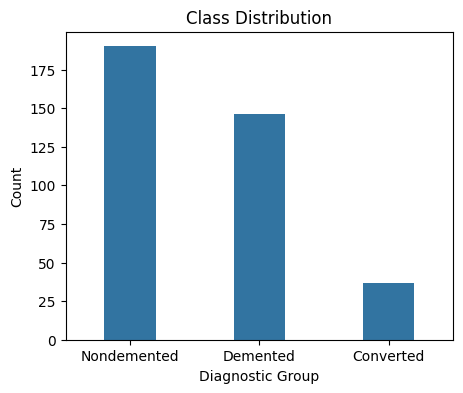

In [8]:
import matplotlib.pyplot as plt
import seaborn as sns

# Group distribution
plt.figure(figsize=(5, 4))
sns.countplot(data=aligned_data, x='Group', order=aligned_data['Group'].value_counts().index, width=0.4)
plt.title("Class Distribution")
plt.xlabel("Diagnostic Group")
plt.ylabel("Count")
plt.show()

In [8]:
aligned_data.describe()

,Visit,MR Delay,Age,EDUC,SES,MMSE,CDR,eTIV,nWBV,ASF
count,373.000000,373.000000,373.000000,373.000000,354.000000,371.000000,373.000000,373.000000,373.000000,373.000000
mean,1.882038,595.104558,77.013405,14.597855,2.460452,27.342318,0.290885,1488.128686,0.729568,1.195461
std,0.922843,635.485118,7.640957,2.876339,1.134005,3.683244,0.374557,176.139286,0.037135,0.138092
min,1.000000,0.000000,60.000000,6.000000,1.000000,4.000000,0.000000,1106.000000,0.644000,0.876000
25%,1.000000,0.000000,71.000000,12.000000,2.000000,27.000000,0.000000,1357.000000,0.700000,1.099000
50%,2.000000,552.000000,77.000000,15.000000,2.000000,29.000000,0.000000,1470.000000,0.729000,1.194000
75%,2.000000,873.000000,82.000000,16.000000,3.000000,30.000000,0.500000,1597.000000,0.756000,1.293000
max,5.000000,2639.000000,98.000000,23.000000,5.000000,30.000000,2.000000,2004.000000,0.837000,1.587000


In [30]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

#  Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_oasis.csv"
val_csv = "val_data_oasis.csv"
test_csv = "test_data_oasis.csv"
image_dir = "oasis_extracted_files/oasis2_preprocessed_images"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# ✅ Load DeiT-Base Model and Image Processor with classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"  
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True  
).to(device)

# Define label mapping 
label_map = {"Nondemented": 0, "Demented": 1, "Converted": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.image_dir, f"{row['MRI ID']}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

# Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

#  Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#  Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5, verbose=True)

#  Training Loop with Early Stopping
epochs = 20
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# Evaluate Model on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f" Test Accuracy: {test_acc:.4f}")

Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 | Train Loss: 0.9713, Train Acc: 0.4904 | Val Loss: 0.9193, Val Acc: 0.5179
Best model saved.
Epoch 2/20 | Train Loss: 0.9162, Train Acc: 0.5402 | Val Loss: 0.9115, Val Acc: 0.5357
Best model saved.
Epoch 3/20 | Train Loss: 0.8893, Train Acc: 0.5824 | Val Loss: 0.9054, Val Acc: 0.5536
Best model saved.
Epoch 4/20 | Train Loss: 0.8538, Train Acc: 0.6284 | Val Loss: 0.8985, Val Acc: 0.5893
Best model saved.
Epoch 5/20 | Train Loss: 0.8258, Train Acc: 0.6552 | Val Loss: 0.8925, Val Acc: 0.5536
Best model saved.
Epoch 6/20 | Train Loss: 0.7940, Train Acc: 0.6858 | Val Loss: 0.8875, Val Acc: 0.5893
Best model saved.
Epoch 7/20 | Train Loss: 0.7650, Train Acc: 0.7088 | Val Loss: 0.8841, Val Acc: 0.6071
Best model saved.
Epoch 8/20 | Train Loss: 0.7341, Train Acc: 0.7241 | Val Loss: 0.8780, Val Acc: 0.6071
Best model saved.
Epoch 9/20 | Train Loss: 0.6982, Train Acc: 0.7548 | Val Loss: 0.8739, Val Acc: 0.6250
Best model saved.
Epoch 10/20 | Train Loss: 0.6657, Train Acc: 0.7893 | V

In [40]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_oasis.csv"
val_csv = "val_data_oasis.csv"
test_csv = "test_data_oasis.csv"
image_dir = "oasis_extracted_files/oasis2_preprocessed_images"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

#  Load DeiT-Base Model and Image Processor with  classifier head
checkpoint = "facebook/deit-base-distilled-patch16-224"  
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True  
).to(device)

# Define label mapping 
label_map = {"Nondemented": 0, "Demented": 1, "Converted": 2}

class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.image_dir, f"{row['MRI ID']}.png")
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

#  Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

#  Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

#  Define Loss and Optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=1e-6)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.01, patience=5, verbose=True)

#  Training Loop with Early Stopping
epochs = 20
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

#  Evaluate Model on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")

Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 | Train Loss: 1.1166, Train Acc: 0.3716 | Val Loss: 0.9831, Val Acc: 0.4643
Best model saved.
Epoch 2/20 | Train Loss: 0.9562, Train Acc: 0.5249 | Val Loss: 0.9611, Val Acc: 0.4464
Best model saved.
Epoch 3/20 | Train Loss: 0.9167, Train Acc: 0.5402 | Val Loss: 0.9553, Val Acc: 0.4643
Best model saved.
Epoch 4/20 | Train Loss: 0.8905, Train Acc: 0.6015 | Val Loss: 0.9505, Val Acc: 0.4821
Best model saved.
Epoch 5/20 | Train Loss: 0.8582, Train Acc: 0.5977 | Val Loss: 0.9476, Val Acc: 0.5000
Best model saved.
Epoch 6/20 | Train Loss: 0.8257, Train Acc: 0.6628 | Val Loss: 0.9446, Val Acc: 0.5000
Best model saved.
Epoch 7/20 | Train Loss: 0.7973, Train Acc: 0.6743 | Val Loss: 0.9440, Val Acc: 0.5357
Best model saved.
Epoch 8/20 | Train Loss: 0.7662, Train Acc: 0.7088 | Val Loss: 0.9495, Val Acc: 0.5179
Epoch 9/20 | Train Loss: 0.7342, Train Acc: 0.7318 | Val Loss: 0.9465, Val Acc: 0.5179
Epoch 10/20 | Train Loss: 0.6994, Train Acc: 0.7510 | Val Loss: 0.9487, Val Acc: 0.5357
Epo

In [9]:
import pandas as pd

# Load the CSV files
train_df = pd.read_csv("train_data_oasis.csv")
val_df = pd.read_csv("val_data_oasis.csv")
test_df = pd.read_csv("test_data_oasis.csv")

# Display the first few rows of each dataframe
print("Training Data Head:")
print(train_df.head())
print("\nValidation Data Head:")
print(val_df.head())
print("\nTest Data Head:")
print(test_df.head())

Training Data Head:
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0040  OAS2_0040_MR1     Demented      1         0   M    R   84     6   
1  OAS2_0119  OAS2_0119_MR1  Nondemented      1         0   F    R   81    15   
2  OAS2_0066  OAS2_0066_MR2     Demented      2       497   M    R   62    18   
3  OAS2_0014  OAS2_0014_MR2     Demented      2       504   M    R   77    16   
4  OAS2_0172  OAS2_0172_MR2     Demented      2      1212   M    R   79    16   

   SES  MMSE  CDR  eTIV   nWBV    ASF  
0  4.0  25.0  0.5  1310  0.727  1.339  
1  2.0  28.0  0.0  1486  0.754  1.181  
2  1.0  30.0  0.5  1928  0.731  0.910  
3  3.0  16.0  1.0  1590  0.696  1.104  
4  1.0  29.0  0.5  1899  0.700  0.924  

Validation Data Head:
  Subject ID         MRI ID        Group  Visit  MR Delay M/F Hand  Age  EDUC  \
0  OAS2_0052  OAS2_0052_MR1  Nondemented      1         0   M    R   74    18   
1  OAS2_0178  OAS2_0178_MR3  Nondemented      3      1447   F    R  

In [1]:
train_csv = "train_data_oasis.csv"
val_csv = "val_data_oasis.csv"
test_csv = "test_data_oasis.csv"

In [8]:
test_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 56 entries, 0 to 55
Data columns (total 15 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Subject ID  56 non-null     object 
 1   MRI ID      56 non-null     object 
 2   Group       56 non-null     object 
 3   Visit       56 non-null     int64  
 4   MR Delay    56 non-null     int64  
 5   M/F         56 non-null     object 
 6   Hand        56 non-null     object 
 7   Age         56 non-null     int64  
 8   EDUC        56 non-null     int64  
 9   SES         48 non-null     float64
 10  MMSE        55 non-null     float64
 11  CDR         56 non-null     float64
 12  eTIV        56 non-null     int64  
 13  nWBV        56 non-null     float64
 14  ASF         56 non-null     float64
dtypes: float64(5), int64(5), object(5)
memory usage: 6.7+ KB


## Refined Images

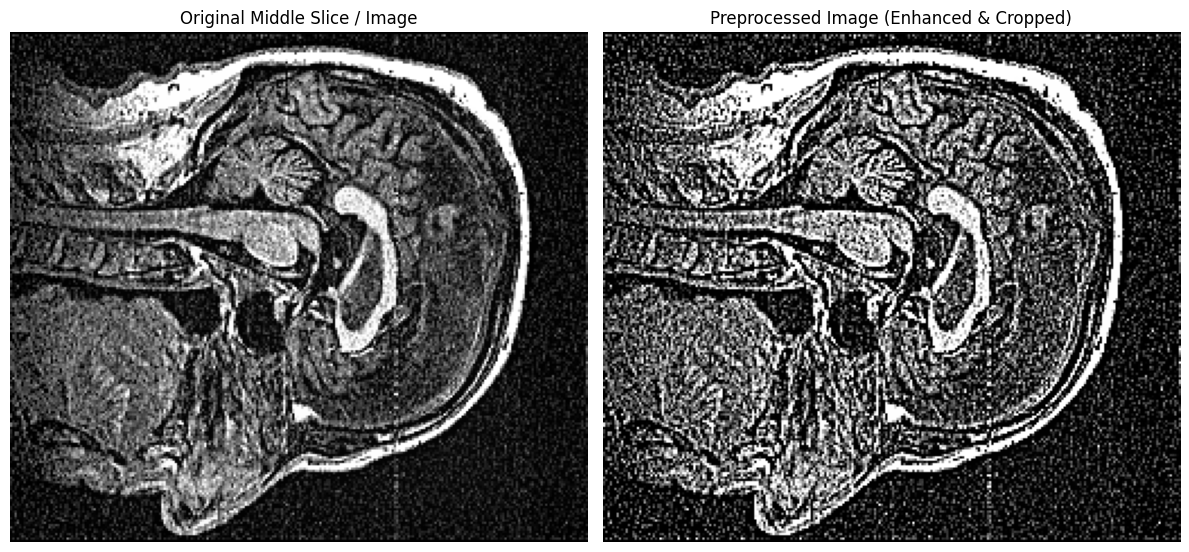

Preprocessed images saved to preprocessed_images_oasis


In [1]:
import os
import nibabel as nib
import numpy as np
import cv2
from PIL import Image
import matplotlib.pyplot as plt
import torch
from skimage import exposure
from skimage.filters import unsharp_mask
from skimage.restoration import denoise_bilateral

# Check if CUDA is available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Input and output directories
input_dir = "oasis_extracted_files/oasis2_preprocessed_images"
output_dir = "preprocessed_images_oasis"
os.makedirs(output_dir, exist_ok=True)

def preprocess_image(file_path):
   
    if file_path.endswith(".nii"):
        # Load NIfTI file and normalize intensities
        img_data = nib.load(file_path).get_fdata()
        normalized_img = (img_data - img_data.min()) / (img_data.max() - img_data.min())
        # Extract the middle axial slice
        middle_slice = normalized_img[:, :, normalized_img.shape[2] // 2]
    elif file_path.endswith(".png"):
        # Load PNG image in grayscale and normalize
        middle_slice = cv2.imread(file_path, cv2.IMREAD_GRAYSCALE)
        if middle_slice is None:
            raise ValueError(f"Unable to load image: {file_path}")
        middle_slice = middle_slice.astype(np.float32) / 255.0
    else:
        raise ValueError(f"Unsupported file format: {file_path}")

    # Contrast Enhancement
    p2, p98 = np.percentile(middle_slice, (2, 98))
    contrast_enhanced = exposure.rescale_intensity(middle_slice, in_range=(p2, p98))
    
    # Sharpening using Unsharp Masking
    sharpened_image = unsharp_mask(contrast_enhanced, radius=1.5, amount=1.5)
    
    # Noise Reduction using Bilateral Filtering (preserves edges)
    denoised_image = denoise_bilateral(sharpened_image, sigma_color=0.05, sigma_spatial=15, channel_axis=None)
    
    # Convert to uint8 for OpenCV processing
    denoised_uint8 = (denoised_image * 255).astype(np.uint8)
    
    # Canny Edge Detection
    edges = cv2.Canny(denoised_uint8, threshold1=50, threshold2=150)
    
    # Morphological Closing to fill gaps in edges
    kernel = np.ones((5, 5), np.uint8)
    edges_closed = cv2.morphologyEx(edges, cv2.MORPH_CLOSE, kernel)
    
    # Find contours and crop to the largest one 
    contours, _ = cv2.findContours(edges_closed, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if contours:
        largest_contour = max(contours, key=cv2.contourArea)
        x, y, w, h = cv2.boundingRect(largest_contour)
        cropped_image = denoised_image[y:y+h, x:x+w]
    else:
        cropped_image = denoised_image  
    
    return cropped_image

# Process all files in the input directory
for file in os.listdir(input_dir):
    if file.endswith(".nii") or file.endswith(".png"):
        file_path = os.path.join(input_dir, file)
        processed_img = preprocess_image(file_path)
        
        # Create output filename with "MRI_ID" prefix
        file_base = os.path.splitext(file)[0]
        output_filename = f"MRI_ID_{file_base}.png"
        output_path = os.path.join(output_dir, output_filename)
        
        # Save the processed image
        Image.fromarray((processed_img * 255).astype(np.uint8)).save(output_path)

# Display a before and after comparison for one sample file 
sample_file = None
for file in os.listdir(input_dir):
    if file.endswith(".nii") or file.endswith(".png"):
        sample_file = os.path.join(input_dir, file)
        break

if sample_file is None:
    raise ValueError("No valid image files found in the input directory.")

if sample_file.endswith(".nii"):
    original_img_data = nib.load(sample_file).get_fdata()
    original_middle_slice = (original_img_data[:, :, original_img_data.shape[2] // 2] - original_img_data.min()) / (original_img_data.max() - original_img_data.min())
elif sample_file.endswith(".png"):
    original_middle_slice = cv2.imread(sample_file, cv2.IMREAD_GRAYSCALE).astype(np.float32) / 255.0

processed_img = preprocess_image(sample_file)

fig, axs = plt.subplots(1, 2, figsize=(12, 6))
axs[0].imshow(original_middle_slice, cmap="gray")
axs[0].set_title("Original Middle Slice / Image")
axs[0].axis("off")

axs[1].imshow(processed_img, cmap="gray")
axs[1].set_title("Preprocessed Image (Enhanced & Cropped)")
axs[1].axis("off")

plt.tight_layout()
plt.show()

print(f"Preprocessed images saved to {output_dir}")


In [30]:
import os

image_dir = "preprocessed_images_oasis"

if not os.path.exists(image_dir):
    print(f"Directory '{image_dir}' does not exist.")
else:
    files = os.listdir(image_dir)
    # Define common image file extensions
    image_extensions = ('.png', '.jpg', '.jpeg', '.bmp', '.tif', '.tiff')
    # Filter files by these extensions (case-insensitive)
    image_files = [f for f in files if f.lower().endswith(image_extensions)]
    
    if image_files:
        print(f"Found {len(image_files)} image file(s) in '{image_dir}':")
        for img in image_files:
            print(img)
    else:
        print(f"No image files found in '{image_dir}'.")


Found 372 image file(s) in 'preprocessed_images_oasis':
MRI_ID_OAS2_0016_MR2.png
MRI_ID_OAS2_0077_MR2.png
MRI_ID_OAS2_0119_MR1.png
MRI_ID_OAS2_0064_MR3.png
MRI_ID_OAS2_0046_MR1.png
MRI_ID_OAS2_0040_MR1.png
MRI_ID_OAS2_0043_MR2.png
MRI_ID_OAS2_0009_MR2.png
MRI_ID_OAS2_0088_MR2.png
MRI_ID_OAS2_0095_MR3.png
MRI_ID_OAS2_0185_MR2.png
MRI_ID_OAS2_0101_MR1.png
MRI_ID_OAS2_0069_MR2.png
MRI_ID_OAS2_0075_MR2.png
MRI_ID_OAS2_0135_MR1.png
MRI_ID_OAS2_0157_MR1.png
MRI_ID_OAS2_0106_MR2.png
MRI_ID_OAS2_0150_MR1.png
MRI_ID_OAS2_0099_MR1.png
MRI_ID_OAS2_0161_MR3.png
MRI_ID_OAS2_0119_MR3.png
MRI_ID_OAS2_0026_MR1.png
MRI_ID_OAS2_0046_MR2.png
MRI_ID_OAS2_0048_MR1.png
MRI_ID_OAS2_0001_MR2.png
MRI_ID_OAS2_0122_MR2.png
MRI_ID_OAS2_0183_MR3.png
MRI_ID_OAS2_0043_MR1.png
MRI_ID_OAS2_0039_MR1.png
MRI_ID_OAS2_0105_MR2.png
MRI_ID_OAS2_0073_MR4.png
MRI_ID_OAS2_0042_MR1.png
MRI_ID_OAS2_0005_MR2.png
MRI_ID_OAS2_0048_MR5.png
MRI_ID_OAS2_0080_MR3.png
MRI_ID_OAS2_0029_MR2.png
MRI_ID_OAS2_0145_MR1.png
MRI_ID_OAS2_0013_MR

In [7]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_oasis.csv"
val_csv = "val_data_oasis.csv"
test_csv = "test_data_oasis.csv"
image_dir = "preprocessed_images_oasis"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# Define label mapping 
label_map = {"Nondemented": 0, "Demented": 1, "Converted": 2}

# Load DeiT-Base model and Image Processor
checkpoint = "facebook/deit-base-distilled-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True
).to(device)

# Dataset Definition
class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
       
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        # Construct filename by adding the "MRI_ID_" prefix to align with file names in the folder.
        img_path = os.path.join(self.image_dir, f"MRI_ID_{row['MRI ID']}.png")
        # Open the image and convert it to RGB.
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

# Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Create PyTorch Datasets
batch_size = 16
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Training Loop with Early Stopping
epochs = 20
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Get logits from the model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# Evaluate on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")


2025-04-14 22:44:03.965093: I tensorflow/tsl/cuda/cudart_stub.cc:28] Could not find cuda drivers on your machine, GPU will not be used.
2025-04-14 22:44:04.006897: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2025-04-14 22:44:04.676714: W tensorflow/compiler/tf2tensorrt/utils/py_utils.cc:38] TF-TRT Warning: Could not find TensorRT


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 | Train Loss: 1.0498, Train Acc: 0.4615 | Val Loss: 0.9754, Val Acc: 0.5179
Best model saved.
Epoch 2/20 | Train Loss: 0.8580, Train Acc: 0.5808 | Val Loss: 0.9207, Val Acc: 0.5536
Best model saved.
Epoch 3/20 | Train Loss: 0.6470, Train Acc: 0.8000 | Val Loss: 0.9051, Val Acc: 0.5893
Best model saved.
Epoch 4/20 | Train Loss: 0.3464, Train Acc: 0.9038 | Val Loss: 0.9872, Val Acc: 0.5357
Epoch 5/20 | Train Loss: 0.0772, Train Acc: 1.0000 | Val Loss: 1.0094, Val Acc: 0.5536
Epoch 6/20 | Train Loss: 0.0177, Train Acc: 1.0000 | Val Loss: 1.2101, Val Acc: 0.5714
Epoch 7/20 | Train Loss: 0.0080, Train Acc: 1.0000 | Val Loss: 1.2088, Val Acc: 0.5714
Epoch 8/20 | Train Loss: 0.0071, Train Acc: 1.0000 | Val Loss: 1.1996, Val Acc: 0.5714
Early stopping triggered.
🔥 Test Accuracy: 0.5714


In [44]:
import os

# Define the directory path
image_dir = "preprocessed_images_oasis"

# Check if the directory exists
if os.path.exists(image_dir):
    print(f"Directory '{image_dir}' exists.")
    
    # Get list of files in the directory
    files = [f for f in os.listdir(image_dir) if os.path.isfile(os.path.join(image_dir, f))]
    
    # Count the number of files
    file_count = len(files)
    print(f"Total number of files: {file_count}")
    
    # Get file formats (extensions)
    file_formats = {}
    for file in files:
        extension = os.path.splitext(file)[1].lower()  
        file_formats[extension] = file_formats.get(extension, 0) + 1
    
    # Display file formats
    print("\nFile formats and their counts:")
    for ext, count in file_formats.items():
        print(f"{ext}: {count}")
    
    # Display first 5 files
    print("\nFirst 5 files:")
    for file in files[:5]:
        print(file)
else:
    print(f"Directory '{image_dir}' does not exist.")

Directory 'preprocessed_images_oasis' exists.
Total number of files: 372

File formats and their counts:
.png: 372

First 5 files:
MRI_ID_OAS2_0016_MR2.png
MRI_ID_OAS2_0077_MR2.png
MRI_ID_OAS2_0119_MR1.png
MRI_ID_OAS2_0064_MR3.png
MRI_ID_OAS2_0046_MR1.png


## Deit Feature extraction for the training, val and test sets

In [33]:
import os
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import DeiTFeatureExtractor, DeiTModel  
from torch.optim.lr_scheduler import ReduceLROnPlateau


optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)
# Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_oasis.csv"
val_csv   = "val_data_oasis.csv"
test_csv  = "test_data_oasis.csv"
image_dir = "oasis_extracted_files/oasis2_preprocessed_images"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data   = pd.read_csv(val_csv)
test_data  = pd.read_csv(test_csv)

#  Load DeiT Model for Feature Extraction
checkpoint = "facebook/deit-base-distilled-patch16-224"
feature_extractor = DeiTFeatureExtractor.from_pretrained(checkpoint)
model = DeiTModel.from_pretrained(checkpoint).to(device)  

#  Define PyTorch Dataset
class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        img_path = os.path.join(self.image_dir, f"{row['MRI ID']}.png")

        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        
        return image

#  Define Transformations for DeiT
transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=feature_extractor.image_mean, std=feature_extractor.image_std)
])

#  Create PyTorch Dataloaders
batch_size = 8
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset   = MRIImageDataset(val_data,   image_dir, transform=transform)
test_dataset  = MRIImageDataset(test_data,  image_dir, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
val_loader   = DataLoader(val_dataset,   batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader  = DataLoader(test_dataset,  batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Extract Features and save as .npy
def extract_features(dataloader, dataset_name):
    model.eval()
    features_list = []
    with torch.no_grad():
        for images in dataloader:
            images = images.to(device)
            
            outputs = model(images).last_hidden_state[:, 0, :].cpu().numpy()
            features_list.append(outputs)
    
    # Concatenate all batch features into a single array
    features_array = np.concatenate(features_list, axis=0)

    # Save as .npy
    np.save(f"Deit_{dataset_name}_features_oasis.npy", features_array)
    print(f"✅ Extracted and saved .npy features for {dataset_name}")

#  Perform Feature Extraction
extract_features(train_loader, "train")
extract_features(val_loader,   "val")
extract_features(test_loader,  "test")


Using device: cuda:1


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/transformers/models/deit/feature_extraction_deit.py:28: FutureWarning: The class DeiTFeatureExtractor is deprecated and will be removed in version 5 of Transformers. Please use DeiTImageProcessor instead.
  warnings.warn(
Some weights of DeiTModel were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['deit.pooler.dense.bias', 'deit.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


✅ Extracted and saved .npy features for train
✅ Extracted and saved .npy features for val
✅ Extracted and saved .npy features for test


In [34]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import classification_report, accuracy_score

train_features = np.load("Deit_train_features_oasis.npy")
val_features   = np.load("Deit_val_features_oasis.npy")
test_features  = np.load("Deit_test_features_oasis.npy")

#  Load Labels
train_labels = train_data["Group"].values
val_labels = val_data["Group"].values
test_labels = test_data["Group"].values

# Check Feature Shapes
print(f"Train Features Shape: {train_features.shape}")  
print(f"Val Features Shape:   {val_features.shape}")  
print(f"Test Features Shape:  {test_features.shape}")  

# Logistic Regression Model
lr_model = LogisticRegression(max_iter=500)
lr_model.fit(train_features, train_labels)

# Evaluate Logistic Regression
lr_preds = lr_model.predict(test_features)
print("🔥 Logistic Regression Performance:")
print(classification_report(test_labels, lr_preds))
print(f"Test Accuracy (LR): {accuracy_score(test_labels, lr_preds):.4f}")

# MLP Classifier 
mlp_model = MLPClassifier(hidden_layer_sizes=(256, 256), activation='relu', solver='adam', max_iter=50, early_stopping=True)
mlp_model.fit(train_features, train_labels)

# Evaluate MLP Classifier
mlp_preds = mlp_model.predict(test_features)
print("🔥 MLP Classifier Performance:")
print(classification_report(test_labels, mlp_preds))
print(f"Test Accuracy (MLP): {accuracy_score(test_labels, mlp_preds):.4f}")

Train Features Shape: (261, 768)
Val Features Shape:   (56, 768)
Test Features Shape:  (56, 768)
🔥 Logistic Regression Performance:
              precision    recall  f1-score   support

   Converted       0.50      0.17      0.25         6
    Demented       0.60      0.55      0.57        22
 Nondemented       0.59      0.71      0.65        28

    accuracy                           0.59        56
   macro avg       0.56      0.48      0.49        56
weighted avg       0.58      0.59      0.57        56

Test Accuracy (LR): 0.5893
🔥 MLP Classifier Performance:
              precision    recall  f1-score   support

   Converted       0.00      0.00      0.00         6
    Demented       0.50      0.73      0.59        22
 Nondemented       0.67      0.57      0.62        28

    accuracy                           0.57        56
   macro avg       0.39      0.43      0.40        56
weighted avg       0.53      0.57      0.54        56

Test Accuracy (MLP): 0.5714


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa

## Deit End to End Classification

In [10]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_oasis.csv"
val_csv = "val_data_oasis.csv"
test_csv = "test_data_oasis.csv"
image_dir = "preprocessed_images_oasis"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# Define label mapping 
label_map = {"Nondemented": 0, "Demented": 1, "Converted": 2}

# Load DeiT-Base model and Image Processor
checkpoint = "facebook/deit-base-distilled-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True
).to(device)

# Dataset Definition
class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        
        img_path = os.path.join(self.image_dir, f"MRI_ID_{row['MRI ID']}.png")
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

# Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)), 
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Create PyTorch Datasets
batch_size = 16
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Training Loop with Early Stopping
epochs = 20
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Get logits from the model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# Evaluate on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 | Train Loss: 1.0108, Train Acc: 0.4943 | Val Loss: 1.0447, Val Acc: 0.3929
Best model saved.
Epoch 2/20 | Train Loss: 0.9502, Train Acc: 0.5096 | Val Loss: 0.9273, Val Acc: 0.5179
Best model saved.
Epoch 3/20 | Train Loss: 0.8459, Train Acc: 0.5824 | Val Loss: 0.9612, Val Acc: 0.5179
Epoch 4/20 | Train Loss: 0.6486, Train Acc: 0.7126 | Val Loss: 0.9643, Val Acc: 0.4821
Epoch 5/20 | Train Loss: 0.3034, Train Acc: 0.9234 | Val Loss: 1.0241, Val Acc: 0.5536
Epoch 6/20 | Train Loss: 0.0958, Train Acc: 1.0000 | Val Loss: 1.0126, Val Acc: 0.5893
Epoch 7/20 | Train Loss: 0.0614, Train Acc: 1.0000 | Val Loss: 1.0240, Val Acc: 0.5893
Early stopping triggered.
🔥 Test Accuracy: 0.6250


## Margn of errors

In [25]:
import os
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from PIL import Image
from transformers import AutoImageProcessor, DeiTForImageClassification
from torch.optim.lr_scheduler import ReduceLROnPlateau

# Check CUDA availability
device = torch.device("cuda:1" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

# Paths to datasets and preprocessed images
train_csv = "train_data_oasis.csv"
val_csv = "val_data_oasis.csv"
test_csv = "test_data_oasis.csv"
image_dir = "preprocessed_images_oasis"

# Load Data Splits
train_data = pd.read_csv(train_csv)
val_data = pd.read_csv(val_csv)
test_data = pd.read_csv(test_csv)

# Define label mapping 
label_map = {"Nondemented": 0, "Demented": 1, "Converted": 2}

# Load DeiT-Base model and Image Processor
checkpoint = "facebook/deit-base-distilled-patch16-224"
image_processor = AutoImageProcessor.from_pretrained(checkpoint)
model = DeiTForImageClassification.from_pretrained(
    checkpoint, num_labels=3, ignore_mismatched_sizes=True
).to(device)

# Dataset Definition
class MRIImageDataset(Dataset):
    def __init__(self, dataframe, image_dir, transform=None):
        
        self.dataframe = dataframe
        self.image_dir = image_dir
        self.transform = transform

    def __len__(self):
        return len(self.dataframe)

    def __getitem__(self, index):
        row = self.dataframe.iloc[index]
        
        img_path = os.path.join(self.image_dir, f"MRI_ID_{row['MRI ID']}.png")
        
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        label = label_map[row["Group"]]
        return image, label

# Define Transformations for DeiT-Base
transform = transforms.Compose([
    transforms.Resize((224, 224)),  
    transforms.ToTensor(),
    transforms.Normalize(mean=image_processor.image_mean, std=image_processor.image_std)
])

# Create PyTorch Datasets
batch_size = 16
train_dataset = MRIImageDataset(train_data, image_dir, transform=transform)
val_dataset = MRIImageDataset(val_data, image_dir, transform=transform)
test_dataset = MRIImageDataset(test_data, image_dir, transform=transform)

# Create DataLoaders
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, pin_memory=True)
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4, pin_memory=True)

# Define Loss, Optimizer, and Scheduler
criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=2e-5)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor=0.1, patience=2, verbose=True)

# Training Loop with Early Stopping
epochs = 20
best_val_loss = float("inf")
best_model_state = None
patience = 5
wait = 0

for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    correct = 0
    total = 0

    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)
        optimizer.zero_grad()
        outputs = model(images).logits  # Get logits from the model
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

    train_loss = running_loss / len(train_dataset)
    train_acc = correct / total

    model.eval()
    running_val_loss = 0.0
    correct_val = 0
    total_val = 0
    with torch.no_grad():
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images).logits
            loss = criterion(outputs, labels)
            running_val_loss += loss.item() * labels.size(0)
            _, predicted = outputs.max(1)
            correct_val += predicted.eq(labels).sum().item()
            total_val += labels.size(0)

    val_loss = running_val_loss / len(val_dataset)
    val_acc = correct_val / total_val

    print(f"Epoch {epoch+1}/{epochs} | Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.4f} | Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}")
    scheduler.step(val_loss)

    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        wait = 0
        print("Best model saved.")
    else:
        wait += 1
        if wait >= patience:
            print("Early stopping triggered.")
            break

if best_model_state:
    model.load_state_dict(best_model_state)

# Evaluate on Test Set
model.eval()
correct = 0
total = 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        correct += predicted.eq(labels).sum().item()
        total += labels.size(0)

test_acc = correct / total
print(f"🔥 Test Accuracy: {test_acc:.4f}")


# ----------------------------------------------------------------
# Margin of Error Calculation for Test Accuracy
# ----------------------------------------------------------------

# Approach 1: Direct Calculation using the Binomial Formula.
n_test = len(test_dataset)  
se = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe = 1.96 * se  # 95% Confidence Interval using z-value ≈ 1.96

print("\nDirect Calculation:")
print("Standard Error: {:.4f}".format(se))
print("Margin of Error (95% CI): {:.4f}".format(moe))
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe, test_acc + moe))

# Approach 2: Bootstrapping
all_preds = []
all_targets = []
model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images).logits
        _, predicted = outputs.max(1)
        all_preds.append(predicted.cpu().numpy())
        all_targets.append(labels.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)

n_bootstrap = 1000
boot_accs = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_test), n_test, replace=True)
    acc_bs = accuracy_score(all_targets[indices], all_preds[indices])
    boot_accs.append(acc_bs)
boot_accs = np.array(boot_accs)
se_boot = np.std(boot_accs)
moe_boot = 1.96 * se_boot

print("\nBootstrapping:")
print("Bootstrapped Mean Accuracy: {:.4f}".format(np.mean(boot_accs)))
print("Standard Error (Bootstrap): {:.4f}".format(se_boot))
print("Margin of Error (Bootstrap, 95% CI): {:.4f}".format(moe_boot))


Using device: cuda:1


Some weights of DeiTForImageClassification were not initialized from the model checkpoint at facebook/deit-base-distilled-patch16-224 and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/20 | Train Loss: 0.9651, Train Acc: 0.5192 | Val Loss: 0.9189, Val Acc: 0.5357
Best model saved.
Epoch 2/20 | Train Loss: 0.8562, Train Acc: 0.6077 | Val Loss: 0.9564, Val Acc: 0.4821
Epoch 3/20 | Train Loss: 0.7249, Train Acc: 0.6500 | Val Loss: 0.8664, Val Acc: 0.6429
Best model saved.
Epoch 4/20 | Train Loss: 0.3880, Train Acc: 0.8846 | Val Loss: 0.8943, Val Acc: 0.5714
Epoch 5/20 | Train Loss: 0.0971, Train Acc: 0.9769 | Val Loss: 1.0830, Val Acc: 0.5893
Epoch 6/20 | Train Loss: 0.0172, Train Acc: 1.0000 | Val Loss: 1.0893, Val Acc: 0.6071
Epoch 7/20 | Train Loss: 0.0073, Train Acc: 1.0000 | Val Loss: 1.0748, Val Acc: 0.6250
Epoch 8/20 | Train Loss: 0.0066, Train Acc: 1.0000 | Val Loss: 1.0758, Val Acc: 0.6250
Early stopping triggered.
🔥 Test Accuracy: 0.6250

Direct Calculation:
Standard Error: 0.0647
Margin of Error (95% CI): 0.1268
95% Confidence Interval for Accuracy: [0.4982, 0.7518]

Bootstrapping:
Bootstrapped Mean Accuracy: 0.6258
Standard Error (Bootstrap): 0.0642


In [26]:
# 9. Compute the Margin of Error for Weighted F1 Score
##########################################
from sklearn.metrics import f1_score

# Compute the Weighted F1 Score on the test set.
weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print("\nWeighted F1 Score: {:.4f}".format(weighted_f1))

# Bootstrapping for Weighted F1 Score.
boot_f1s = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_samples), n_samples, replace=True)
    f1_bs = f1_score(np.array(all_targets)[indices], np.array(all_preds)[indices], average='weighted')
    boot_f1s.append(f1_bs)
boot_f1s = np.array(boot_f1s)
se_boot_f1 = np.std(boot_f1s)
moe_boot_f1 = 1.96 * se_boot_f1
print("\nBootstrapping for Weighted F1 Score:")
print("Bootstrapped Mean Weighted F1: {:.4f}".format(np.mean(boot_f1s)))
print("Standard Error (Bootstrap) for Weighted F1: {:.4f}".format(se_boot_f1))
print("Margin of Error (Bootstrap, 95% CI) for Weighted F1: {:.4f}".format(moe_boot_f1))


Weighted F1 Score: 0.6008

Bootstrapping for Weighted F1 Score:
Bootstrapped Mean Weighted F1: 0.6010
Standard Error (Bootstrap) for Weighted F1: 0.0685
Margin of Error (Bootstrap, 95% CI) for Weighted F1: 0.1343


## FT-Transformer Model end to end training and validation

In [13]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from rtdl_revisiting_models import FTTransformer


# 1. Load the Data
train_data = pd.read_csv("train_data_oasis.csv")
val_data   = pd.read_csv("val_data_oasis.csv")
test_data  = pd.read_csv("test_data_oasis.csv")


# 2. Select Features and Label
numerical_features = ["Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV"]
label = "Group"


cols = numerical_features + [label]
train_data = train_data[cols]
val_data   = val_data[cols]
test_data  = test_data[cols]


# 3. Handle Missingness for Continuous Features


# Calculate mean from training data and apply to all sets
mmse_mean = train_data["MMSE"].mean()

for df in [train_data, val_data, test_data]:
    df["MMSE"] = df["MMSE"].fillna(mmse_mean)


numerical_features_extended = numerical_features  


# 4. Encode Target

label_encoder = LabelEncoder()
train_data[label] = label_encoder.fit_transform(train_data[label])
val_data[label]   = label_encoder.transform(val_data[label])
test_data[label]  = label_encoder.transform(test_data[label])
num_classes = len(label_encoder.classes_)


# 5. Prepare NumPy Arrays for Model Inputs

X_train_cont = train_data[numerical_features_extended].values.astype(np.float32)
X_val_cont   = val_data[numerical_features_extended].values.astype(np.float32)
X_test_cont  = test_data[numerical_features_extended].values.astype(np.float32)

# Labels
y_train = train_data[label].values.astype(np.int64)
y_val   = val_data[label].values.astype(np.int64)
y_test  = test_data[label].values.astype(np.int64)


# 6. Create a PyTorch Dataset

class TabularDataset(Dataset):
    def __init__(self, cont, labels):
        self.cont = cont
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "cont": torch.tensor(self.cont[idx], dtype=torch.float32),
            "target": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TabularDataset(X_train_cont, y_train)
val_dataset   = TabularDataset(X_val_cont, y_val)
test_dataset  = TabularDataset(X_test_cont, y_test)


# 7. Create DataLoaders

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 8. Initialize the FTTransformer Model

n_cont_features = X_train_cont.shape[1]
d_out = num_classes

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=[],  
    d_out=d_out,
    n_blocks=3,
    d_block=192,
    attention_n_heads=8,
    attention_dropout=0.2,
    ffn_d_hidden=None,
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.1,
    residual_dropout=0.0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# 9. Set Up Optimizer, Loss, and Scheduler
optimizer = torch.optim.Adam(model.parameters(), lr=2e-3)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)


# 10. Train the Model with Early Stopping
max_epochs = 100
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cont = batch["cont"].to(device)
        targets = batch["target"].to(device)
        
        optimizer.zero_grad()
        logits = model(cont, None)  
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * cont.size(0)
    train_loss /= len(train_dataset)
    
    # Validation loop
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            cont = batch["cont"].to(device)
            targets = batch["target"].to(device)
            
            logits = model(cont, None)
            loss = criterion(logits, targets)
            val_loss += loss.item() * cont.size(0)
    val_loss /= len(val_dataset)
    
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


# 11. Save the Best Model
save_model_path = "best_ft_transformer_oasis.pt"
torch.save(best_model_state, save_model_path)
print("Model saved to", save_model_path)


# 12. Load the Best Model
model.load_state_dict(torch.load(save_model_path))


# 13. Evaluate on the Test Set
model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        cont = batch["cont"].to(device)
        targets = batch["target"].to(device)
        
        logits = model(cont, None)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report (Test):")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 1.0529 | Val Loss: 0.9543
Epoch 2: Train Loss: 0.9915 | Val Loss: 0.9280
Epoch 3: Train Loss: 0.9732 | Val Loss: 0.9241
Epoch 4: Train Loss: 0.9546 | Val Loss: 0.9283
Epoch 5: Train Loss: 0.9709 | Val Loss: 0.9240
Epoch 6: Train Loss: 0.9584 | Val Loss: 0.9226
Epoch 7: Train Loss: 0.9562 | Val Loss: 0.9204
Epoch 8: Train Loss: 0.9442 | Val Loss: 0.9200
Epoch 9: Train Loss: 0.9320 | Val Loss: 0.8834
Epoch 10: Train Loss: 0.8573 | Val Loss: 0.6450
Epoch 11: Train Loss: 0.6691 | Val Loss: 0.3951
Epoch 12: Train Loss: 0.6269 | Val Loss: 0.3451
Epoch 13: Train Loss: 0.8123 | Val Loss: 0.6765
Epoch 14: Train Loss: 0.8169 | Val Loss: 0.5285
Epoch 15: Train Loss: 0.7645 | Val Loss: 0.3886
Epoch 16: Train Loss: 0.7276 | Val Loss: 0.3969
Epoch 17: Train Loss: 0.6968 | Val Loss: 0.4198
Early stopping triggered.
Model saved to best_ft_transformer_oasis.pt
Test Accuracy: 0.8928571428571429
Classification Report (Test):
              precision    recall  f1-score   support

   C

/tmp/ipykernel_1122648/900641631.py:185: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path))
/home/sran-m36/Multi Modal Project/

## Margin of Error

In [11]:
import pandas as pd
import numpy as np
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, f1_score
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
from rtdl_revisiting_models import FTTransformer  
import math


# 1. Load the Data
train_data = pd.read_csv("train_data_oasis.csv")
val_data   = pd.read_csv("val_data_oasis.csv")
test_data  = pd.read_csv("test_data_oasis.csv")


# 2. Select Features and Label
numerical_features = ["Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV"]
label = "Group"

cols = numerical_features + [label]
train_data = train_data[cols]
val_data   = val_data[cols]
test_data  = test_data[cols]


# 3. Handle Missingness for Continuous Features

mmse_mean = train_data["MMSE"].mean()
for df in [train_data, val_data, test_data]:
    df["MMSE"] = df["MMSE"].fillna(mmse_mean)

numerical_features_extended = numerical_features  


# 4. Encode Target

label_encoder = LabelEncoder()
train_data[label] = label_encoder.fit_transform(train_data[label])
val_data[label]   = label_encoder.transform(val_data[label])
test_data[label]  = label_encoder.transform(test_data[label])
num_classes = len(label_encoder.classes_)


# 5. Prepare NumPy Arrays for Model Inputs

X_train_cont = train_data[numerical_features_extended].values.astype(np.float32)
X_val_cont   = val_data[numerical_features_extended].values.astype(np.float32)
X_test_cont  = test_data[numerical_features_extended].values.astype(np.float32)

y_train = train_data[label].values.astype(np.int64)
y_val   = val_data[label].values.astype(np.int64)
y_test  = test_data[label].values.astype(np.int64)


# 6. Create a PyTorch Dataset

class TabularDataset(Dataset):
    def __init__(self, cont, labels):
        self.cont = cont
        self.labels = labels
        
    def __len__(self):
        return len(self.labels)
    
    def __getitem__(self, idx):
        return {
            "cont": torch.tensor(self.cont[idx], dtype=torch.float32),
            "target": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TabularDataset(X_train_cont, y_train)
val_dataset   = TabularDataset(X_val_cont, y_val)
test_dataset  = TabularDataset(X_test_cont, y_test)


# 7. Create DataLoaders

batch_size = 32
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 8. Initialize the FTTransformer Model

n_cont_features = X_train_cont.shape[1]
d_out = num_classes

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=[],  
    d_out=d_out,
    n_blocks=3,
    d_block=192,
    attention_n_heads=8,
    attention_dropout=0.2,
    ffn_d_hidden=None,
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.1,
    residual_dropout=0.0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)


# 9. Set Up Optimizer, Loss, and Scheduler

optimizer = torch.optim.AdamW(model.parameters(), lr=2e-3, weight_decay=1e-5)
criterion = nn.CrossEntropyLoss()
scheduler = torch.optim.lr_scheduler.ReduceLROnPlateau(
    optimizer, mode='min', patience=3, factor=0.5, verbose=True
)


# 10. Train the Model with Early Stopping

max_epochs = 100
patience = 5
best_val_loss = float('inf')
patience_counter = 0

for epoch in range(max_epochs):
    model.train()
    train_loss = 0.0
    for batch in train_loader:
        cont = batch["cont"].to(device)
        targets = batch["target"].to(device)
        
        optimizer.zero_grad()
        logits = model(cont, None)  
        loss = criterion(logits, targets)
        loss.backward()
        optimizer.step()
        
        train_loss += loss.item() * cont.size(0)
    train_loss /= len(train_dataset)
    
    model.eval()
    val_loss = 0.0
    with torch.no_grad():
        for batch in val_loader:
            cont = batch["cont"].to(device)
            targets = batch["target"].to(device)
            
            logits = model(cont, None)
            loss = criterion(logits, targets)
            val_loss += loss.item() * cont.size(0)
    val_loss /= len(val_dataset)
    
    scheduler.step(val_loss)
    print(f"Epoch {epoch+1}: Train Loss: {train_loss:.4f} | Val Loss: {val_loss:.4f}")
    
    if val_loss < best_val_loss:
        best_val_loss = val_loss
        best_model_state = model.state_dict()
        patience_counter = 0
    else:
        patience_counter += 1
        if patience_counter >= patience:
            print("Early stopping triggered.")
            break


# 11. Save the Best Model

save_model_path = "best_ft_transformer_oasis.pt"
torch.save(best_model_state, save_model_path)
print("Model saved to", save_model_path)


# 12.  Load the Best Model

model.load_state_dict(torch.load(save_model_path))


# 13. Evaluate on the Test Set

model.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        cont = batch["cont"].to(device)
        targets = batch["target"].to(device)
        
        logits = model(cont, None)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(targets.cpu().numpy())

all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report (Test):")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))
conf_matrix = confusion_matrix(all_targets, all_preds)
print("Confusion Matrix:")
print(conf_matrix)


# --- Accuracy Margin of Error ---

# Approach 1: Direct Calculation using the Binomial Formula.
n_test = len(all_targets)
se_direct = math.sqrt(test_acc * (1 - test_acc) / n_test)
moe_direct = 1.96 * se_direct
print("\nDirect Calculation for Accuracy:")
print("Standard Error: {:.4f}".format(se_direct))
print("Margin of Error (95% CI): {:.4f}".format(moe_direct))
print("95% Confidence Interval for Accuracy: [{:.4f}, {:.4f}]".format(test_acc - moe_direct, test_acc + moe_direct))

# Approach 2: Bootstrapping for Accuracy.
n_bootstrap = 1000
boot_accs = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_test), n_test, replace=True)
    acc_bs = accuracy_score(all_targets[indices], all_preds[indices])
    boot_accs.append(acc_bs)
boot_accs = np.array(boot_accs)
se_bootstrap = np.std(boot_accs)
moe_bootstrap = 1.96 * se_bootstrap
print("\nBootstrapping for Accuracy:")
print("Bootstrapped Mean Accuracy: {:.4f}".format(np.mean(boot_accs)))
print("Standard Error (Bootstrap): {:.4f}".format(se_bootstrap))
print("Margin of Error (Bootstrap, 95% CI): {:.4f}".format(moe_bootstrap))

# --- Weighted F1 Score Margin of Error ---
weighted_f1 = f1_score(all_targets, all_preds, average='weighted')
print("\nWeighted F1 Score:", weighted_f1)

# Bootstrapping for Weighted F1 Score.
boot_f1s = []
for i in range(n_bootstrap):
    indices = np.random.choice(np.arange(n_test), n_test, replace=True)
    f1_bs = f1_score(all_targets[indices], all_preds[indices], average='weighted')
    boot_f1s.append(f1_bs)
boot_f1s = np.array(boot_f1s)
se_boot_f1 = np.std(boot_f1s)
moe_boot_f1 = 1.96 * se_boot_f1
print("\nBootstrapping for Weighted F1 Score:")
print("Bootstrapped Mean Weighted F1: {:.4f}".format(np.mean(boot_f1s)))
print("Standard Error (Bootstrap) for Weighted F1: {:.4f}".format(se_boot_f1))
print("Margin of Error (Bootstrap, 95% CI) for Weighted F1: {:.4f}".format(moe_boot_f1))


/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/torch/optim/lr_scheduler.py:60: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Epoch 1: Train Loss: 1.0297 | Val Loss: 0.9456
Epoch 2: Train Loss: 0.9859 | Val Loss: 0.9331
Epoch 3: Train Loss: 0.9500 | Val Loss: 0.9167
Epoch 4: Train Loss: 0.9493 | Val Loss: 0.8823
Epoch 5: Train Loss: 0.8661 | Val Loss: 0.7002
Epoch 6: Train Loss: 0.6289 | Val Loss: 0.3660
Epoch 7: Train Loss: 0.5920 | Val Loss: 0.3217
Epoch 8: Train Loss: 0.6275 | Val Loss: 0.3649
Epoch 9: Train Loss: 0.6127 | Val Loss: 0.3618
Epoch 10: Train Loss: 0.7396 | Val Loss: 0.4633
Epoch 11: Train Loss: 0.6127 | Val Loss: 0.3533
Epoch 12: Train Loss: 0.4970 | Val Loss: 0.3323
Early stopping triggered.
Model saved to best_ft_transformer_oasis.pt
Test Accuracy: 0.8928571428571429
Classification Report (Test):
              precision    recall  f1-score   support

   Converted       0.00      0.00      0.00         6
    Demented       0.88      1.00      0.94        22
 Nondemented       0.90      1.00      0.95        28

    accuracy                           0.89        56
   macro avg       0.59    

/tmp/ipykernel_163706/3136728897.py:179: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(save_model_path))
/home/sran-m36/Multi Modal Project/


Bootstrapping for Accuracy:
Bootstrapped Mean Accuracy: 0.8924
Standard Error (Bootstrap): 0.0405
Margin of Error (Bootstrap, 95% CI): 0.0794

Weighted F1 Score: 0.8423574262016381

Bootstrapping for Weighted F1 Score:
Bootstrapped Mean Weighted F1: 0.8439
Standard Error (Bootstrap) for Weighted F1: 0.0595
Margin of Error (Bootstrap, 95% CI) for Weighted F1: 0.1166


## feature extractiion using the ft-transformer model

In [14]:
import pandas as pd
import numpy as np
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from rtdl_revisiting_models import FTTransformer


# 1. Load and Preprocess the Data

train_data = pd.read_csv("train_data_oasis.csv")
val_data   = pd.read_csv("val_data_oasis.csv")
test_data  = pd.read_csv("test_data_oasis.csv")

numerical_features = ["Age", "EDUC", "MMSE", "CDR", "eTIV", "nWBV"]
label = "Group"

cols = numerical_features + [label]
train_data = train_data[cols]
val_data   = val_data[cols]
test_data  = test_data[cols]

# Handle missingness 
mmse_mean = train_data["MMSE"].mean()
for df in [train_data, val_data, test_data]:
    df["MMSE"] = df["MMSE"].fillna(mmse_mean)

numerical_features_extended = numerical_features  

# Encode target
label_encoder = LabelEncoder()
train_data[label] = label_encoder.fit_transform(train_data[label])
val_data[label]   = label_encoder.transform(val_data[label])
test_data[label]  = label_encoder.transform(test_data[label])


# 2. Prepare Data and Create Datasets

def get_arrays(df):
    cont = df[numerical_features_extended].values.astype(np.float32)
    target = df[label].values.astype(np.int64)
    return cont, target

X_train_cont, y_train = get_arrays(train_data)
X_val_cont, y_val = get_arrays(val_data)
X_test_cont, y_test = get_arrays(test_data)

class TabularDataset(Dataset):
    def __init__(self, cont, labels):
        self.cont = cont
        self.labels = labels
    def __len__(self):
        return len(self.labels)
    def __getitem__(self, idx):
        return {
            "cont": torch.tensor(self.cont[idx], dtype=torch.float32),
            "target": torch.tensor(self.labels[idx], dtype=torch.long)
        }

train_dataset = TabularDataset(X_train_cont, y_train)
val_dataset   = TabularDataset(X_val_cont, y_val)
test_dataset  = TabularDataset(X_test_cont, y_test)

batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)


# 3. Load the Pretrained FTTransformer Model

n_cont_features = X_train_cont.shape[1]
num_classes = len(label_encoder.classes_)  

model = FTTransformer(
    n_cont_features=n_cont_features,
    cat_cardinalities=[],  
    d_out=num_classes,
    n_blocks=3,
    d_block=192,
    attention_n_heads=8,
    attention_dropout=0.2,
    ffn_d_hidden=None,
    ffn_d_hidden_multiplier=4/3,
    ffn_dropout=0.1,
    residual_dropout=0.0
)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

save_model_path = "best_ft_transformer_oasis.pt"  
model.load_state_dict(torch.load(save_model_path, map_location=device, weights_only=True))
model.eval()


# 4. Register a Hook to Capture Penultimate Features

penultimate_features = []

def hook_fn(module, input, output):
    penultimate_features.append(input[0].detach())

hook_handle = model.backbone.output[2].register_forward_hook(hook_fn)


# 5. Define a Function to Extract Embeddings

def extract_embeddings(loader, model, device):
    global penultimate_features
    penultimate_features = []
    model.eval()
    with torch.no_grad():
        for batch in loader:
            cont = batch["cont"].to(device)
            _ = model(cont, None)  
    embeddings = torch.cat(penultimate_features, dim=0)
    return embeddings


# 6. Extract and Save Embeddings for All Sets

embeddings_train = extract_embeddings(train_loader, model, device)
embeddings_val   = extract_embeddings(val_loader, model, device)
embeddings_test  = extract_embeddings(test_loader, model, device)

print("Extracted train embeddings shape:", embeddings_train.shape)
print("Extracted validation embeddings shape:", embeddings_val.shape)
print("Extracted test embeddings shape:", embeddings_test.shape)

# Save embeddings with "_oasis" suffix
np.save("ft_train_embeddings_oasis.npy", embeddings_train.cpu().numpy())
np.save("ft_val_embeddings_oasis.npy", embeddings_val.cpu().numpy())
np.save("ft_test_embeddings_oasis.npy", embeddings_test.cpu().numpy())
print("Embeddings saved to disk with '_oasis' suffix.")

# Remove the hook
hook_handle.remove()

Extracted train embeddings shape: torch.Size([261, 192])
Extracted validation embeddings shape: torch.Size([56, 192])
Extracted test embeddings shape: torch.Size([56, 192])
Embeddings saved to disk with '_oasis' suffix.


In [18]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report

# Set device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

##########################################
# 1. Load Saved Embeddings
##########################################
train_embeddings = np.load("ft_train_embeddings_oasis.npy")
val_embeddings   = np.load("ft_val_embeddings_oasis.npy")
test_embeddings  = np.load("ft_test_embeddings_oasis.npy")

##########################################
# 2. Load Labels (from CSV files)
##########################################
train_data = pd.read_csv("train_data_oasis.csv")
val_data   = pd.read_csv("val_data_oasis.csv")
test_data  = pd.read_csv("test_data_oasis.csv")

label = "Group"

# Encode labels using LabelEncoder
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_data[label])
val_labels   = label_encoder.transform(val_data[label])
test_labels  = label_encoder.transform(test_data[label])

# Number of classes
num_classes = len(label_encoder.classes_)

##########################################
# 3. Create PyTorch Datasets and DataLoaders
##########################################
# Convert embeddings and labels to tensors
train_embeddings = torch.tensor(train_embeddings, dtype=torch.float32)
val_embeddings   = torch.tensor(val_embeddings, dtype=torch.float32)
test_embeddings  = torch.tensor(test_embeddings, dtype=torch.float32)

train_labels = torch.tensor(train_labels, dtype=torch.long)
val_labels   = torch.tensor(val_labels, dtype=torch.long)
test_labels  = torch.tensor(test_labels, dtype=torch.long)

# Create TensorDatasets
train_dataset = TensorDataset(train_embeddings, train_labels)
val_dataset   = TensorDataset(val_embeddings, val_labels)
test_dataset  = TensorDataset(test_embeddings, test_labels)

# Create DataLoaders
batch_size = 8
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
val_loader   = DataLoader(val_dataset, batch_size=batch_size, shuffle=False)
test_loader  = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

##########################################
# 4. Define an MLP Classifier
##########################################
class MLPClassifier(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_classes):
        super(MLPClassifier, self).__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Dropout(0.2),
            nn.Linear(hidden_dim, num_classes)
        )
    def forward(self, x):
        return self.net(x)

input_dim = 192      
hidden_dim = 128     
model_mlp = MLPClassifier(input_dim, hidden_dim, num_classes)
model_mlp.to(device)

##########################################
# 5. Train the MLP Classifier
##########################################
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_mlp.parameters(), lr=1e-3)
num_epochs = 50

for epoch in range(num_epochs):
    model_mlp.train()
    train_loss = 0.0
    for batch in train_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        optimizer.zero_grad()
        logits = model_mlp(x)
        loss = criterion(logits, y)
        loss.backward()
        optimizer.step()
        train_loss += loss.item() * x.size(0)
    train_loss /= len(train_dataset)
    
    # Evaluate on the validation set
    model_mlp.eval()
    all_preds = []
    all_targets = []
    with torch.no_grad():
        for batch in val_loader:
            x, y = batch
            x, y = x.to(device), y.to(device)
            logits = model_mlp(x)
            preds = torch.argmax(logits, dim=1)
            all_preds.append(preds.cpu().numpy())
            all_targets.append(y.cpu().numpy())
    all_preds = np.concatenate(all_preds)
    all_targets = np.concatenate(all_targets)
    val_acc = accuracy_score(all_targets, all_preds)
    print(f"Epoch {epoch+1}/{num_epochs}: Train Loss = {train_loss:.4f}, Val Acc = {val_acc:.4f}")

##########################################
# 6. Evaluate on the Test Set
##########################################
model_mlp.eval()
all_preds = []
all_targets = []
with torch.no_grad():
    for batch in test_loader:
        x, y = batch
        x, y = x.to(device), y.to(device)
        logits = model_mlp(x)
        preds = torch.argmax(logits, dim=1)
        all_preds.append(preds.cpu().numpy())
        all_targets.append(y.cpu().numpy())
all_preds = np.concatenate(all_preds)
all_targets = np.concatenate(all_targets)
test_acc = accuracy_score(all_targets, all_preds)
print("Test Accuracy:", test_acc)
print("Classification Report:")
print(classification_report(all_targets, all_preds, target_names=[str(c) for c in label_encoder.classes_]))

Epoch 1/50: Train Loss = 0.6496, Val Acc = 0.9107
Epoch 2/50: Train Loss = 0.3920, Val Acc = 0.9107
Epoch 3/50: Train Loss = 0.4036, Val Acc = 0.9107
Epoch 4/50: Train Loss = 0.3828, Val Acc = 0.9107
Epoch 5/50: Train Loss = 0.3920, Val Acc = 0.9107
Epoch 6/50: Train Loss = 0.3682, Val Acc = 0.9107
Epoch 7/50: Train Loss = 0.3910, Val Acc = 0.9107
Epoch 8/50: Train Loss = 0.3752, Val Acc = 0.9107
Epoch 9/50: Train Loss = 0.3703, Val Acc = 0.9107
Epoch 10/50: Train Loss = 0.3857, Val Acc = 0.9107
Epoch 11/50: Train Loss = 0.3769, Val Acc = 0.9107
Epoch 12/50: Train Loss = 0.3875, Val Acc = 0.9107
Epoch 13/50: Train Loss = 0.3771, Val Acc = 0.9107
Epoch 14/50: Train Loss = 0.3857, Val Acc = 0.9107
Epoch 15/50: Train Loss = 0.3909, Val Acc = 0.9107
Epoch 16/50: Train Loss = 0.3904, Val Acc = 0.9107
Epoch 17/50: Train Loss = 0.3768, Val Acc = 0.9107
Epoch 18/50: Train Loss = 0.3748, Val Acc = 0.9107
Epoch 19/50: Train Loss = 0.3846, Val Acc = 0.9107
Epoch 20/50: Train Loss = 0.3769, Val Ac

/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/sran-m36/Multi Modal Project/multimodal_env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1471: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _wa